## Accès et exportation de la base de délinquance

In [51]:
import requests
import pandas as pd


api_root_delinquance = "https://tabular-api.data.gouv.fr/api/resources/"
ID_delinquance = "3f51212c-f7d2-4aec-b899-06be6cdd1030"
filtre = "?CODGEO_2024__greater=75101&CODGEO_2024__less=75120." # Filtre pour ne sélectionner que les arrondissements de Paris 
url_api_delinquance = api_root_delinquance + ID_delinquance + "/data/" + filtre 

print(url_api_delinquance)


def recuperation_data(url_api):
    df = []  
    current_url = url_api

    while current_url:
        req = requests.get(current_url)
        wb = req.json()
        df.extend(wb['data'])
        current_url = wb["links"].get("next")
    return pd.DataFrame(df)

df_delinquance = recuperation_data(url_api_delinquance)
df_delinquance.head() 

https://tabular-api.data.gouv.fr/api/resources/3f51212c-f7d2-4aec-b899-06be6cdd1030/data/?CODGEO_2024__greater=75101&CODGEO_2024__less=75120.


,__id,CODGEO_2024,annee,classe,unité.de.compte,valeur.publiée,faits,tauxpourmille,complementinfoval,complementinfotaux,POP,millPOP,LOG,millLOG
0,409781,75101,16,Coups et blessures volontaires,victime,diff,271.0,"1,66748707851341e+01",NaN,NaN,16252,16,"1,37973242421027e+04",16
1,409782,75101,16,Coups et blessures volontaires intrafamiliaux,victime,diff,33.0,"2,03051932069899e+00",NaN,NaN,16252,16,"1,37973242421027e+04",16
2,409783,75101,16,Autres coups et blessures volontaires,victime,diff,238.0,"1,46443514644351e+01",NaN,NaN,16252,16,"1,37973242421027e+04",16
3,409784,75101,16,Violences sexuelles,victime,diff,93.0,"5,72237263106079e+00",NaN,NaN,16252,16,"1,37973242421027e+04",16
4,409785,75101,16,Vols avec armes,infraction,diff,28.0,"1,72286487816884e+00",NaN,NaN,16252,16,"1,37973242421027e+04",16


In [60]:
df_delinquance.info()
df_delinquance.head()


<class 'pandas.core.frame.DataFrame'>
Index: 2080 entries, 0 to 2239
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   __id                2080 non-null   int64  
 1   CODGEO_2024         2080 non-null   object 
 2   annee               2080 non-null   int64  
 3   classe              2080 non-null   object 
 4   unité.de.compte     2080 non-null   object 
 5   valeur.publiée      2080 non-null   object 
 6   faits               2068 non-null   float64
 7   tauxpourmille       2068 non-null   float64
 8   complementinfoval   12 non-null     float64
 9   complementinfotaux  12 non-null     float64
 10  POP                 2080 non-null   int64  
 11  millPOP             2080 non-null   int64  
 12  LOG                 2080 non-null   object 
 13  millLOG             2080 non-null   int64  
 14  arrondissement      2080 non-null   object 
dtypes: float64(4), int64(5), object(6)
memory usage: 260.0+ KB


,__id,CODGEO_2024,annee,classe,unité.de.compte,valeur.publiée,faits,tauxpourmille,complementinfoval,complementinfotaux,POP,millPOP,LOG,millLOG,arrondissement
0,409781,75101,16,Coups et blessures volontaires,victime,diff,271.0,16.674871,NaN,NaN,16252,16,"1,37973242421027e+04",16,01
2,409783,75101,16,Autres coups et blessures volontaires,victime,diff,238.0,14.644351,NaN,NaN,16252,16,"1,37973242421027e+04",16,01
3,409784,75101,16,Violences sexuelles,victime,diff,93.0,5.722373,NaN,NaN,16252,16,"1,37973242421027e+04",16,01
4,409785,75101,16,Vols avec armes,infraction,diff,28.0,1.722865,NaN,NaN,16252,16,"1,37973242421027e+04",16,01
5,409786,75101,16,Vols violents sans arme,infraction,diff,584.0,35.934039,NaN,NaN,16252,16,"1,37973242421027e+04",16,01


## Sélection des types de crimes et délinquance


In [58]:
valeurs_uniques = df_delinquance['classe'].unique()
print("Valeurs uniques dans la colonne 'classe':")
print(valeurs_uniques)

Valeurs uniques dans la colonne 'classe':
['Coups et blessures volontaires' 'Autres coups et blessures volontaires'
 'Violences sexuelles' 'Vols avec armes' 'Vols violents sans arme'
 'Vols sans violence contre des personnes' 'Cambriolages de logement'
 'Vols de véhicules' 'Vols dans les véhicules'
 "Vols d'accessoires sur véhicules"
 'Destructions et dégradations volontaires' 'Trafic de stupéfiants'
 'Usage de stupéfiants']


In [68]:
df_delinquance['arrondissement'] = df_delinquance['CODGEO_2024'].astype(str).str[-2:]
df_delinquance = df_delinquance[df_delinquance['classe'] != 'Coups et blessures volontaires intrafamiliaux']

df_delinquance.head()


,__id,CODGEO_2024,annee,classe,unité.de.compte,valeur.publiée,faits,tauxpourmille,complementinfoval,complementinfotaux,POP,millPOP,LOG,millLOG,arrondissement
0,409781,75101,16,Coups et blessures volontaires,victime,diff,271.0,16.674871,NaN,NaN,16252,16,"1,37973242421027e+04",16,01
2,409783,75101,16,Autres coups et blessures volontaires,victime,diff,238.0,14.644351,NaN,NaN,16252,16,"1,37973242421027e+04",16,01
3,409784,75101,16,Violences sexuelles,victime,diff,93.0,5.722373,NaN,NaN,16252,16,"1,37973242421027e+04",16,01
4,409785,75101,16,Vols avec armes,infraction,diff,28.0,1.722865,NaN,NaN,16252,16,"1,37973242421027e+04",16,01
5,409786,75101,16,Vols violents sans arme,infraction,diff,584.0,35.934039,NaN,NaN,16252,16,"1,37973242421027e+04",16,01


On s'intéresse ici à tous les faits de délinquance commis entre les années 2016 et 2023. 

In [62]:
# Création d'un data frame simplifié donnant le nombre de faits de délinquance pour mille habitants par arrondissement
delinquance_par_arrondissement = df_delinquance.groupby(['arrondissement']).agg({'tauxpourmille': 'sum'}).reset_index()
delinquance_par_arrondissement


,arrondissement,tauxpourmille
0,01,5196.200318
1,02,2146.200884
2,03,1312.664131
3,04,1789.615948
4,05,912.244964
5,06,1170.924386
6,07,980.394686
7,08,3081.655488
8,09,1685.968091
9,10,1632.879669


## Visualisation du nombre de faits de délinquance par arrondissement à Paris

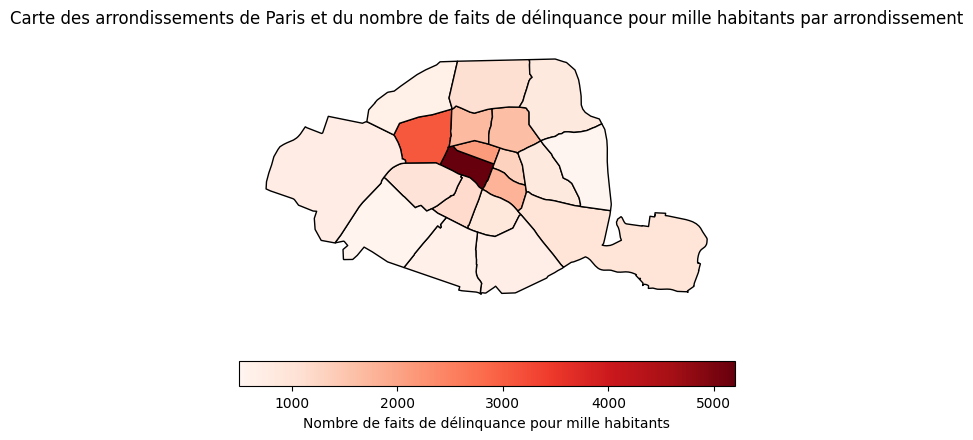

In [63]:
import geopandas as gpd
import matplotlib.pyplot as plt
from cartiflette import carti_download

arr_borders = carti_download(
    crs=4326,
    values=["75"],
    borders="COMMUNE_ARRONDISSEMENT",
    vectorfile_format="geojson",
    filter_by="DEPARTEMENT",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

arr_borders = arr_borders.to_crs(2154)  

arr_borders['arrondissement'] = arr_borders['INSEE_COG'].str[-2:]  
arr_borders_sorted = arr_borders.sort_values(by='arrondissement')
arr_borders_sorted['tauxpourmille'] = delinquance_par_arrondissement['tauxpourmille'].values

carte = arr_borders_sorted.plot(
    column="tauxpourmille",  
    cmap="Reds",        
    legend=True,             
    edgecolor="black",       
    legend_kwds={"label": "Nombre de faits de délinquance pour mille habitants", "orientation": "horizontal"},
)

carte.set_axis_off()  
carte.set_title("Carte des arrondissements de Paris et du nombre de faits de délinquance pour mille habitants par arrondissement")

plt.show()


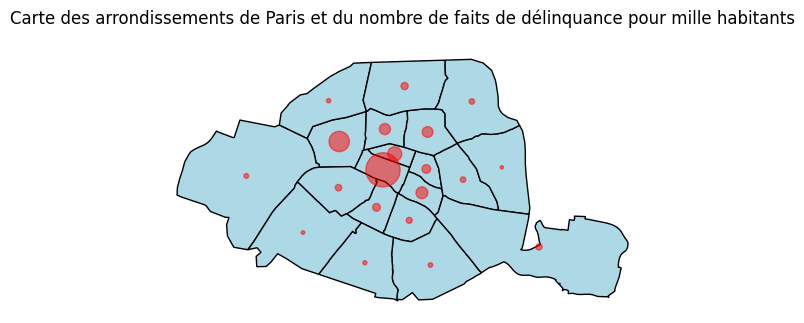

In [69]:
arr_borders = arr_borders.to_crs(epsg=3857)

# Calcul et ajout des centres gémoétriques de chaque arrondissement 
arr_borders['centroid'] = arr_borders.geometry.centroid
arr_borders['arrondissement'] = arr_borders['INSEE_COG'].str[-2:]  

# Tracé du fond de carte des arrondissements
fig, ax = plt.subplots()
arr_borders.plot(ax=ax, color='lightblue', edgecolor='black')  
arr_borders_sorted = arr_borders.sort_values(by='arrondissement')
arr_borders_sorted['tauxpourmille'] = delinquance_par_arrondissement['tauxpourmille'].values

# Ajout du cercle de rayon proportionnel aux de criminalité au centre de chaque arrondissement 
for _, row in arr_borders_sorted.iterrows():
    arrondissement = row['arrondissement']
    taux = row['tauxpourmille']

    if taux > 0: 
        x, y = row['centroid'].x, row['centroid'].y
        radius = taux / 5  
        circle = plt.Circle((x, y), radius, color='red', alpha=0.5, zorder=10)
        ax.add_artist(circle)


ax.set_aspect('equal') 
ax.set_title("Carte des arrondissements de Paris et du nombre de faits de délinquance pour mille habitants")
ax.set_axis_off()  

plt.show()


## Distribution des types de délinquance par arrondissement

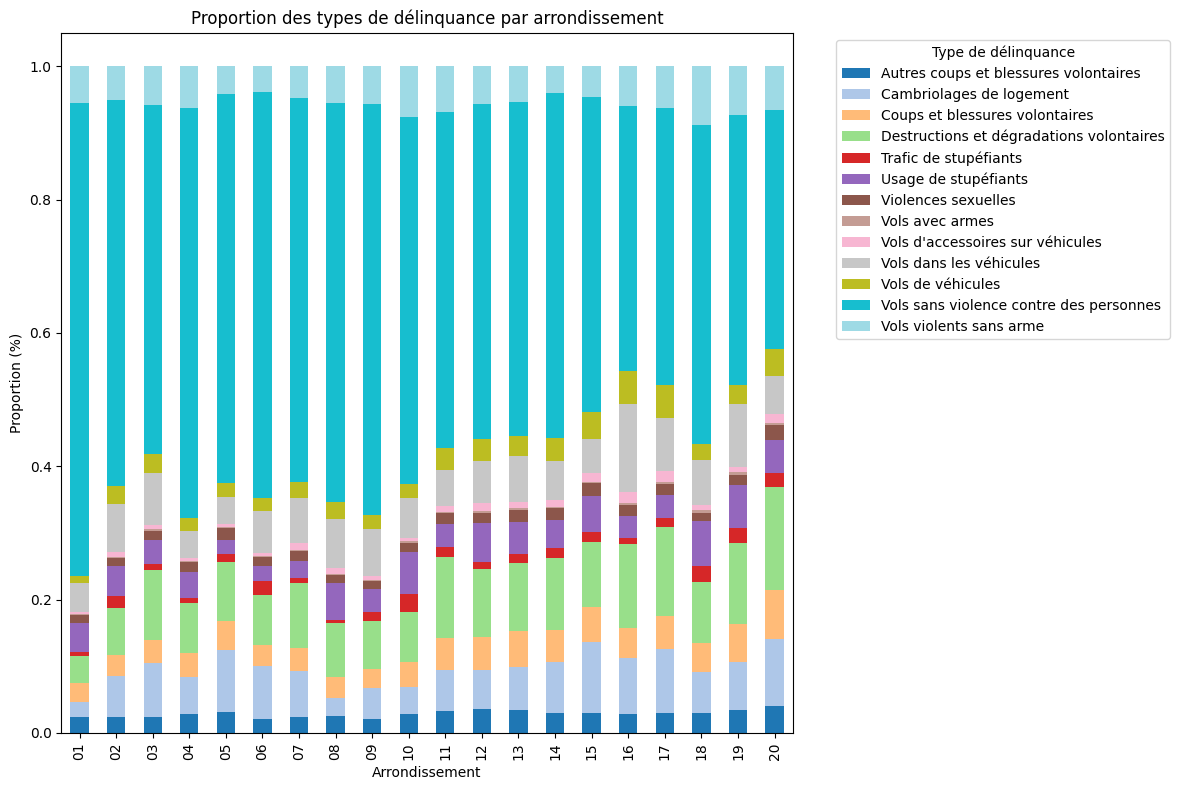

In [71]:

# Normalisation par arrondissement pour obtenir les proportions
df_delinquance_normalized = df_delinquance.copy()
df_delinquance_normalized['taux_normalise'] = df_delinquance_normalized.groupby('arrondissement')['tauxpourmille'].transform(lambda x: x / x.sum())

# Groupement des données par arrondissement et type de crime
grouped_data = df_delinquance_normalized.groupby(['arrondissement', 'classe'])['taux_normalise'].sum().unstack()

# Tracé du graphique en barres empilées
ax = grouped_data.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    colormap='tab20',
    title="Proportion des types de délinquance par arrondissement"
)

plt.xlabel("Arrondissement")
plt.ylabel("Proportion (%)")
plt.legend(title="Type de délinquance", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
